# Classic Unsupervised Machine Learning on PAN Data

In [0]:
#Data managment 
import pandas as pd 
import numpy as np 

#Vizualization 
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
plt.style.use('seaborn-whitegrid')

#Sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score

#Utilities
import pickle
import os

In [0]:
#Get data, small file so no if
if not os.path.isfile('all_scaled0_1.csv'): 
    !wget 'https://drive.google.com/uc?export=download&id=1-ET9vXPKudU92XuWeR0wIL67byS2llq-' -O all_scaled0_1.csv
if not os.path.isfile('no_rfe_scaled0_1.csv'): 
    !wget 'https://drive.google.com/uc?export=download&id=1-6Z60VHL0gk3pd8hKF7-btW_cM_DWTB6' -O no_rfe_scaled0_1.csv
if not os.path.isfile('models.7z'): 
    !wget 'https://drive.google.com/uc?export=download&id=1RPhLO70ip98tvbb4YImXPtEn1Sgz9svy' -O models.7z
    !7z x models.7z

##Parse Data

In [0]:
#data_file = 'all_scaled0_1.csv'
#folder = 'models/all/'
data_file = 'no_rfe_scaled0_1.csv'
folder = 'models/no_rfe/'

In [0]:
data = pd.read_csv(data_file,index_col=0)
labels = data['label']
run = data['run']
chunkID = data['chunkID']
period = data['period']
data = data.drop(['label','chunkID','run','period'], axis = 1)

no_samples, no_features = data.shape

print(no_samples, no_features)
print(labels.value_counts())

data.head()

3429 133
0.0    3262
1.0     167
Name: label, dtype: int64


,bz,meanTPCnclF,meanTPCChi2,rmsTPCChi2,slopeATPCnclF,slopeCTPCnclF,slopeATPCnclFErr,slopeCTPCnclFErr,meanTPCncl,rmsTPCncl,slopeCTPCncl,slopeCTPCnclErr,hasRawQA,rawSignalCounter,slopedZA,offsetdZC,slopedZC,offsetdZAErr,slopedZAErr,offsetdZAchi2,slopedZAchi2,offsetdZCPos,offsetdZAchi2Pos,slopedZAchi2Pos,offsetdZCchi2Pos,slopedZCchi2Pos,slopedZANeg,offsetdZCNeg,slopedZCNeg,offsetdZAchi2Neg,slopedZAchi2Neg,offsetdZCchi2Neg,slopedZCchi2Neg,offsetdRC,offsetdRAchi2,slopedRAchi2,offsetdRCchi2,slopedRCchi2,dcarAP0,dcarCP0,...,dcar_negA_chi2,dcar_negA_0_Err,dcar_negA_1_Err,dcar_negA_2_Err,dcaz_negA_0,dcaz_negA_1,dcaz_negA_0_Err,dcaz_negA_1_Err,dcaz_negA_2_Err,dcaz_negC_chi2,dcaz_negC_0_Err,dcaz_negC_1_Err,dcaz_negC_2_Err,dcar_negC_chi2,dcar_negC_0_Err,dcar_negC_1_Err,dcar_negC_2_Err,iroc_A_side,oroc_A_side,iroc_C_side,oroc_C_side,tpcItsMatchA,tpcItsMatchC,phiPullHighPt,ptPull,ptPullHighPt,yPullHighPt,zPull,zPullHighPt,lambdaPull,meanPTRelativeA,medianPTRelativeA,rmsPTRelativeA,medianPTRelativeC,meanHVandPTGainCorrIROC,medianHVandPTGainCorrIROC,meanHVandPTGainCorrOROC,medianHVandPTGainCorrOROC,meanVDriftCorr,rmsVDriftCorr
0,0.0,0.650378,0.586648,0.299807,0.567304,0.506033,0.029799,0.506033,0.661859,0.130696,0.432987,0.432987,1.0,0.630747,0.505639,0.456515,0.479150,0.029047,0.025431,0.066360,0.066360,0.422997,0.018955,0.018955,0.103951,0.103951,0.347511,0.486962,0.366647,0.135214,0.135214,0.154272,0.154272,0.104897,0.041065,0.041065,0.165264,0.165264,0.023750,0.012700,...,0.040081,0.089056,0.082068,0.091172,0.387952,0.529658,0.075152,0.073086,0.076870,0.049049,0.064750,0.062988,0.066403,0.096599,0.092639,0.089595,0.096029,1.0,1.0,1.0,1.0,0.532074,0.586826,0.558088,0.489128,0.478282,0.397318,0.303648,0.494765,0.564013,0.644374,0.643025,0.030060,0.644593,0.644385,0.643058,0.731516,0.730402,0.062052,0.033067
1,0.0,0.652363,0.579001,0.299619,0.553643,0.490807,0.028887,0.490807,0.662852,0.129801,0.431335,0.431335,1.0,0.630747,0.471739,0.656468,0.622429,0.028192,0.024807,0.098105,0.098105,0.626295,0.078152,0.078152,0.195836,0.195836,0.318030,0.662324,0.531044,0.126243,0.126243,0.205944,0.205944,0.184002,0.120756,0.120756,0.277622,0.277622,0.023131,0.013681,...,0.029575,0.088029,0.080961,0.090309,0.368447,0.537606,0.074312,0.072295,0.075983,0.053690,0.062965,0.061329,0.064488,0.080482,0.090666,0.087815,0.093847,1.0,1.0,1.0,1.0,0.529813,0.583827,0.618659,0.506106,0.508984,0.428699,0.344592,0.458420,0.559882,0.645829,0.644559,0.044541,0.646086,0.645843,0.644604,0.732617,0.731569,0.061865,0.008953
2,0.0,0.656779,0.582115,0.302841,0.576802,0.486826,0.028507,0.486826,0.664891,0.128520,0.414198,0.414198,1.0,0.630747,0.424595,0.774050,0.716557,0.027634,0.024176,0.102944,0.102944,0.748653,0.144460,0.144460,0.224404,0.224404,0.301996,0.760046,0.627993,0.067836,0.067836,0.248870,0.248870,0.229955,0.088526,0.088526,0.349164,0.349164,0.022454,0.013235,...,0.040652,0.088169,0.080976,0.090568,0.377793,0.560263,0.073681,0.071540,0.075483,0.070414,0.062983,0.061441,0.064412,0.067023,0.090231,0.087507,0.093285,1.0,1.0,1.0,1.0,0.534614,0.584458,0.572836,0.508496,0.493338,0.420849,0.341413,0.461882,0.561373,0.645117,0.644090,0.046651,0.645604,0.645142,0.644119,0.732088,0.731203,0.061668,0.027615
3,0.0,0.650338,0.590880,0.307098,0.573718,0.465535,0.029239,0.465535,0.657125,0.127972,0.413237,0.413237,1.0,0.630747,0.453121,0.865839,0.786867,0.029305,0.025690,0.074307,0.074307,0.849890,0.084640,0.084640,0.224069,0.224069,0.307199,0.833085,0.699755,0.059567,0.059567,0.296804,0.296804,0.268384,0.103972,0.103972,0.427887,0.427887,0.023129,0.016565,...,0.024053,0.088482,0.081358,0.090786,0.376294,0.584689,0.074933,0.072717,0.076810,0.095369,0.064623,0.062784,0.066359,0.065335,0.091349,0.088426,0.094600,1.0,1.0,1.0,1.0,0.520301,0.572863,0.602295,0.511802,0.537189,0.439337,0.365844,0.496001,0.529956,0.639891,0.637870,0.174869,0.639382,0.639929,0.637938,0.728152,0.726535,0.061461,0.007084
4,0.0,0.654262,0.591539,0.319091,0.584242,0.494138,0.028849,0.494138,0.663947,0.132655,

## t-SNE

### Classic Outliers

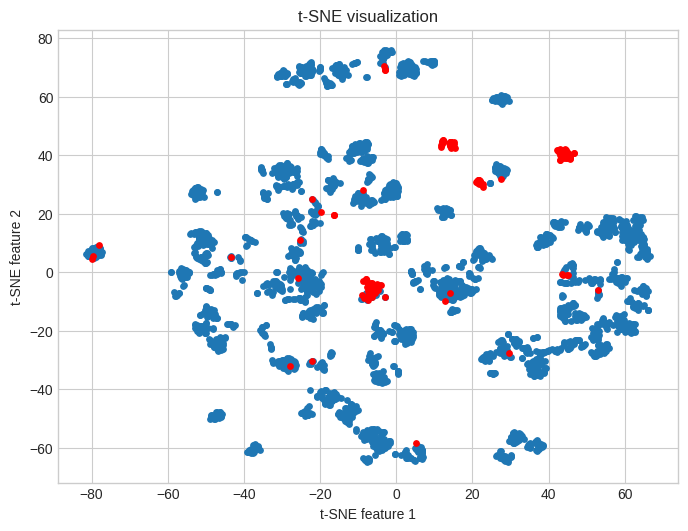

In [0]:
X_embedded = pickle.load(open(folder+'t_sne.pkl','rb'))

corr = X_embedded[labels == 0]
wrong = X_embedded[labels == 1]

fig = plt.figure(figsize = (8,6), dpi= 100)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(corr[:,0], corr[:,1], s=15)
ax.scatter(wrong[:,0], wrong[:,1], color='red', s=15)

ax.set_title('t-SNE visualization')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2');

### Runs

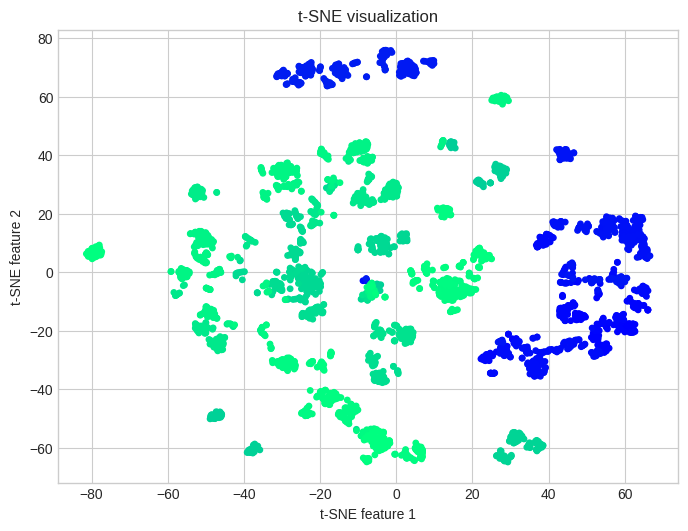

In [0]:
fig = plt.figure(figsize = (8,6), dpi= 100)
ax = fig.add_subplot(1, 1, 1)

cmap = cm.winter
norm = mpl.colors.Normalize(vmin=287000, vmax=294925) #max and min no of run

ax.scatter(X_embedded[:,0], X_embedded[:,1], s=15, c = run,norm=norm, cmap=cmap)

ax.set_title('t-SNE visualization')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2');

## ML

In [0]:
#Split data and stratify so that same proportion of labelled elements is in both sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,stratify=labels)
y_train.value_counts()

0.0    2609
1.0     134
Name: label, dtype: int64

## k-means

In [0]:
%%capture
clf0 = pickle.load(open(folder+'k_means.pkl','rb'))
clf0.transform(data)

In [0]:
#Number of found outliers
pd.Series(clf0.labels_).value_counts()

1    2301
0    1128
dtype: int64

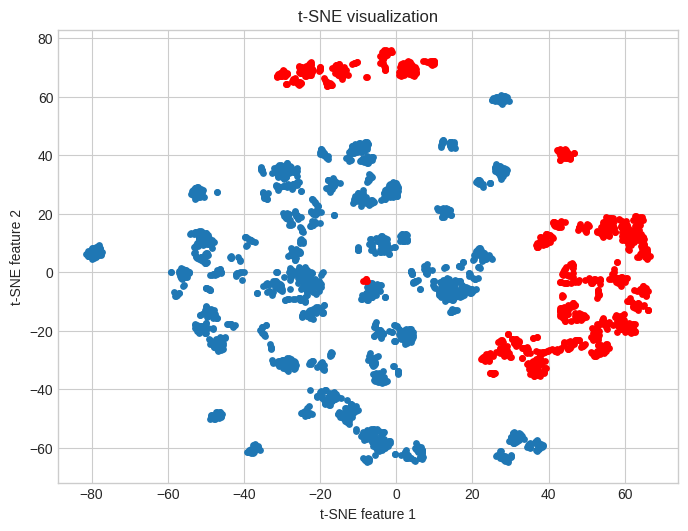

In [0]:
corr = X_embedded[clf0.labels_ == 1]
wrong = X_embedded[clf0.labels_ == 0]

fig = plt.figure(figsize = (8,6), dpi= 100)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(corr[:,0], corr[:,1], s=15)
ax.scatter(wrong[:,0], wrong[:,1], color='red', s=15)

ax.set_title('t-SNE visualization')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2');

## DBSCAN

In [0]:
%%capture
clf1 = pickle.load(open(folder+'dbscan.pkl','rb'))
clf1.fit_predict(data)

In [0]:
#Number of found outliers
pd.Series(clf1.labels_).value_counts()

 6    1996
 0     796
 2     264
-1     130
 8      47
 1      45
 7      40
 3      40
 4      36
 5      35
dtype: int64

In [0]:
#Number of matching outliers with warinings
n_1 = np.where(labels == 1, 1, 0)
n_2 = np.where(clf1.labels_ == -1, 1, 0)
n = np.where((n_1 == 1) & (n_2 == 1), 1, 0)
sum(n)

102

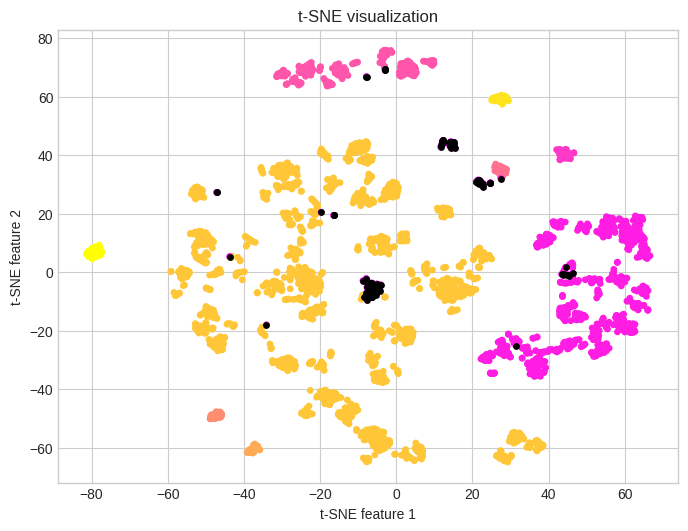

In [0]:
fig = plt.figure(figsize = (8,6), dpi= 100)
ax = fig.add_subplot(1, 1, 1)

cmap = cm.spring
norm = mpl.colors.Normalize(vmin=min(clf1.labels_), vmax=max(clf1.labels_)) #max and min no of run

ax.scatter(X_embedded[:,0], X_embedded[:,1], s=15, c = clf1.labels_,norm=norm, cmap=cmap)

outliers = X_embedded[clf1.labels_ == -1]
ax.scatter(outliers[:,0], outliers[:,1], s=15, color = 'black')

ax.set_title('t-SNE visualization')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2');

## Isolation Forest

In [0]:
%%capture
clf2 = pickle.load(open(folder+'isolation_forest.pkl','rb'))
clf2.predict(data)

In [0]:
pd.Series(clf2.predict(data)).value_counts()

 1    3257
-1     172
dtype: int64

In [0]:
#Number of matching outliers with warinings
n_1 = np.where(labels == 1, 1, 0)
n_2 = np.where(clf2.predict(data) == -1, 1, 0)
n = np.where((n_1 == 1) & (n_2 == 1), 1, 0)
sum(n)

133

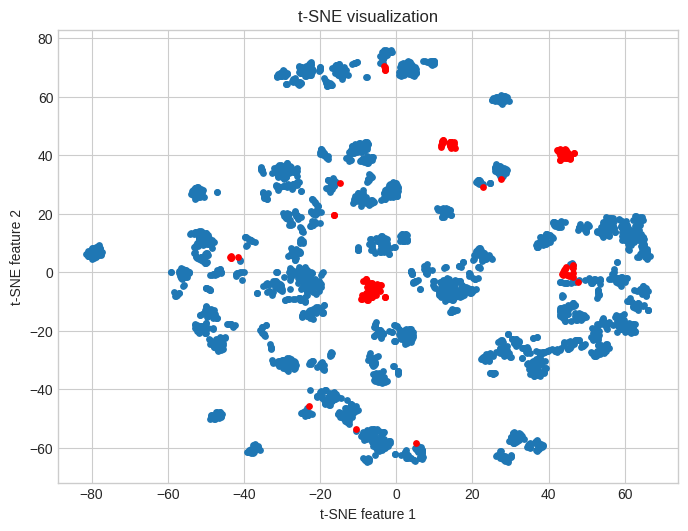

In [0]:
corr = X_embedded[clf2.predict(data) == 1]
wrong = X_embedded[clf2.predict(data) == -1]

fig = plt.figure(figsize = (8,6), dpi= 100)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(corr[:,0], corr[:,1], s=15)
ax.scatter(wrong[:,0], wrong[:,1], color='red', s=15)

ax.set_title('t-SNE visualization')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2');